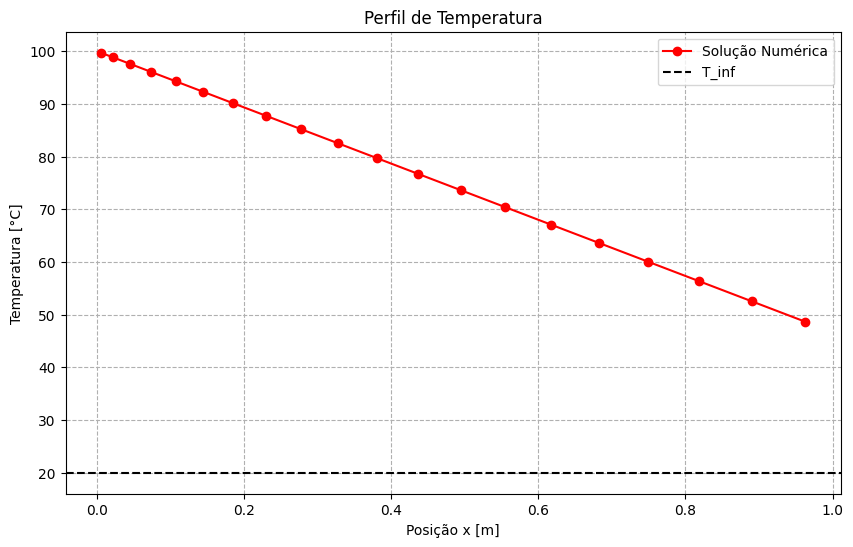

Temperatura na extremidade: 48.64 °C


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Dados iniciais
L = 1.0            # Comprimento [m]
k = 50.0           # Condutividade [W/mK]
h = 100.0          # Coeficiente de convecção [W/m2K]
T_inf = 20.0       # Temp. do fluido [C]
T_base = 100.0     # Temp. na base x=0 [C]
Area = 0.01        # Área [m2]
N = 20             # Número de volumes

# Malha
faces = L * (np.linspace(0, 1, N + 1)**1.5) 
nodos = (faces[1:] + faces[:-1]) / 2
dx = np.diff(faces)

# Montagem da matriz
aw = np.zeros(N)
ae = np.zeros(N)
ap = np.zeros(N)
b = np.zeros(N)

for i in range(N):
    # Coeficiente West (W)
    if i == 0:
        dist_w = nodos[i] - faces[0]
        aw[i] = 0 # CC Dirichlet tratada no ap e b
        ap[i] += (k * Area) / dist_w
        b[i] += ((k * Area) / dist_w) * T_base
    else:
        dist_w = nodos[i] - nodos[i-1]
        aw[i] = (k * Area) / dist_w
        ap[i] += aw[i]

    # Coeficiente East (E)
    if i == N-1:
        # CONDIÇÃO DE ROBIN
        dist_pl = faces[-1] - nodos[i]
        ae_equiv = (h * Area * k) / (k + h * dist_pl)
        ae[i] = 0
        ap[i] += ae_equiv
        b[i] += ae_equiv * T_inf
    else:
        dist_e = nodos[i+1] - nodos[i]
        ae[i] = (k * Area) / dist_e
        ap[i] += ae[i]

# Solvrr TDMA
def solve_tdma(a, b, c, d):
    n = len(d)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    for i in range(1, n):
        m = ac[i]/bc[i-1]
        bc[i] = bc[i] - m*cc[i-1]
        dc[i] = dc[i] - m*dc[i-1]
    res = bc
    res[-1] = dc[-1]/bc[-1]
    for i in range(n-2, -1, -1):
        res[i] = (dc[i]-cc[i]*res[i+1])/bc[i]
    return res

T = solve_tdma(-aw, ap, -ae, b)

# Pplotagem
plt.figure(figsize=(10, 6))
plt.plot(nodos, T, 'r-o', label='Solução Numérica')
plt.axhline(T_inf, color='k', linestyle='--', label='T_inf')
plt.title('Perfil de Temperatura')
plt.xlabel('Posição x [m]')
plt.ylabel('Temperatura [°C]')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.show()

print(f"Temperatura na extremidade: {T[-1]:.2f} °C")